In [13]:
import numpy as np
from skimage import exposure
#from skimage.segmentation import quickshift, slic, watershed
import geopandas as gpd
from osgeo import gdal, ogr
import scipy
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import skimage.feature as feature
import math
from skimage import io, segmentation, color, feature

from hyperopt import hp,fmin,tpe,STATUS_OK,Trials

from skimage.measure import regionprops_table
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, cohen_kappa_score

import warnings
warnings.filterwarnings("ignore") 
import os

In [14]:
#RGB SEGMENTAÇÃO (2m)
naip_raw = r'D:\PROJETO_SC\DADOS_CLASSIFICADOR\RGB_2m.tif'

# COMPOSITE (NIR) (2m)
naip_fn = r'D:\PROJETO_SC\DADOS_CLASSIFICADOR\RGB_NIR_2M.tif'

# SEGMENTO
naip_seg = r'D:\PROJETO_SC\DADOS_CLASSIFICADOR\SEGMENT_2.tif'

# AMOSTRAS
Amostras = r'D:\PROJETO_SC\DADOS_CLASSIFICADOR\amostras_q120.shp'

# Segmentation

In [ ]:
# Open the stacked band satellite data
dataseg = gdal.Open(naip_raw)
driverTiff = gdal.GetDriverByName('GTiff')

# Read the stacked bands into a NumPy array
img_stack = np.zeros((dataseg.RasterCount, dataseg.RasterYSize, dataseg.RasterXSize), dtype=np.float32)
for i in range(dataseg.RasterCount):
    band = dataset.GetRasterBand(i+1)
    img_stack[i,:,:] = band.ReadAsArray().astype(np.float32)
    band = None

# Convert stacked bands to RGB image
img_rgb = np.transpose(img_stack, (1,2,0))

img_rgb_normalized = exposure.rescale_intensity(img_rgb, in_range='image', out_range=(0, 1))

img_lab = color.rgb2lab(img_rgb_normalized)
segments = slic(img_rgb_normalized, n_segments=250000, compactness = 2.5, sigma = 0.01)


## Classification

In [3]:
# COMPOSITE

driverTiff = gdal.GetDriverByName('GTiff')
naip_ds = gdal.Open(naip_fn)
nbands = naip_ds.RasterCount
band_data = []

for i in range(1, nbands+1):
    band = naip_ds.GetRasterBand(i).ReadAsArray()

    band_data.append(band)

band_data = np.dstack(band_data)

band_data = exposure.rescale_intensity(band_data)


In [11]:
# INDEXES
nir_band = band_data[:, :, 3] 
red_band = band_data[:, :, 2] 
green_band = band_data[:, :, 1] 

ndvi = (nir_band - red_band) / (nir_band + red_band)
ndwi = (green_band-nir_band)/(green_band+nir_band)

img = np.dstack((band_data, ndvi, ndwi))


print(img.shape) 

(11393, 11392, 6)


In [9]:
# #IMPORT SEGMENT

# driverTiff = gdal.GetDriverByName('GTiff')
# naip_ds = gdal.Open(naip_seg)
# segments = naip_ds.GetRasterBand(1).ReadAsArray()

In [10]:
def std(regionmask, intensity):
    return np.std(intensity[regionmask])

def quartiles(regionmask, intensity):
    return np.percentile(intensity[regionmask], q=(25, 50, 75))

def kurt(regionmask, intensity):
    return scipy.stats.kurtosis(intensity[regionmask])

def skew(regionmask, intensity):
    return scipy.stats.skew(intensity[regionmask])


#'axis_major_length', 'axis_minor_length'
# Extract properties for all bands at once
props = regionprops_table(segments, intensity_image=img,
                          properties=['intensity_max', 'intensity_min', 'intensity_mean' ], extra_properties = (skew, kurt, std))


objects = pd.DataFrame(props).replace(np.nan,0).values.tolist()

In [13]:
segment_ids = np.unique(segments)
object_ids = np.arange(len(segment_ids))

In [14]:
# read shapefile to geopandas geodataframe
gdf = gpd.read_file(Amostras)
# get names of land cover classes/labels
class_names = gdf['label'].unique()
# create a unique id (integer) for each land cover class/label
class_ids = np.arange(class_names.size) + 1
# create a pandas data frame of the labels and ids and save to csv
df = pd.DataFrame({'label': class_names, 'id': class_ids})
#df.to_csv(r'C:\Users\10333076966\Desktop\Landsat\RESULTADOS\1991_L5\Amostras_1991\class_lookup.csv')
# add a new column to geodatafame with the id for each class/label
gdf['id'] = gdf['label'].map(dict(zip(class_names, class_ids)))
 
# split the truth data into training and test data sets and save each to a new shapefile
gdf_train = gdf.sample(frac=0.90)  # 90% of observations assigned to training data (30% to test data)
gdf_test = gdf.drop(gdf_train.index)
# save training and test data to shapefiles
gdf_train.to_file(os.path.join(os.path.dirname(naip_fn), 'train_data.shp'))
gdf_test.to_file(os.path.join(os.path.dirname(naip_fn), 'test_data.shp'))
print(f'os labels serão: \n {df}' )

os labels serão: 
         label  id
0       pinus   1
1   eucalipto   2
2      nativa   3
3  campoeagro   4
4     exposto   5
5        agua   6


In [15]:
train_fn = os.path.join(os.path.dirname(naip_fn), 'train_data.shp')
train_ds = ogr.Open(train_fn)
lyr = train_ds.GetLayer()
# create a new raster layer in memory
driver = gdal.GetDriverByName('MEM')
target_ds = driver.Create('', naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_UInt16)
target_ds.SetGeoTransform(naip_ds.GetGeoTransform())
target_ds.SetProjection(naip_ds.GetProjection())
# rasterize the training points
options = ['ATTRIBUTE=id']
gdal.RasterizeLayer(target_ds, [1], lyr, options=options)
# retrieve the rasterized data and print basic stats
data = target_ds.GetRasterBand(1).ReadAsArray()

In [16]:
# rasterized observation (truth, training and test) data
ground_truth = target_ds.GetRasterBand(1).ReadAsArray()

# get unique values (0 is the background, or no data, value so it is not included) for each land cover type

classes = np.unique(ground_truth)[1:]

# for each class (land cover type) record the associated segment IDs
segments_per_class = {}
for klass in classes:
    segments_of_class = segments[ground_truth == klass]
    segments_per_class[klass] = set(segments_of_class)

In [17]:
train_img = np.copy(segments)
threshold = train_img.max() + 1  # make the threshold value greater than any land cover class value

# all pixels in training segments assigned value greater than threshold
for klass in classes:
    class_label = threshold + klass
    for segment_id in segments_per_class[klass]:
        train_img[train_img == segment_id] = class_label
 
# training segments receive land cover class value, all other segments 0
train_img[train_img <= threshold] = 0
train_img[train_img > threshold] -= threshold


# create objects and labels for training data
training_objects = []
training_labels = []
for klass in classes:
    class_train_object = [v for i, v in enumerate(objects) if segment_ids[i] in segments_per_class[klass]]
    training_labels += [klass] * len(class_train_object)
    training_objects += class_train_object


# TESTING DATA

In [18]:
#testing data

test_fn = os.path.join(os.path.dirname(naip_fn), 'test_data.shp')
test_ds = ogr.Open(test_fn)
lyr = test_ds.GetLayer()
# create a new raster layer in memory
driver = gdal.GetDriverByName('MEM')
target_test = driver.Create('', naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_UInt16)
target_test.SetGeoTransform(naip_ds.GetGeoTransform())
target_test.SetProjection(naip_ds.GetProjection())
# rasterize the training points
options = ['ATTRIBUTE=id']
gdal.RasterizeLayer(target_test, [1], lyr, options=options)
# retrieve the rasterized data and print basic stats


# rasterized observation (truth, training and test) data
ground_truth_test = target_test.GetRasterBand(1).ReadAsArray()

# get unique values (0 is the background, or no data, value so it is not included) for each land cover type
classes_test = np.unique(ground_truth_test)[1:]

# for each class (land cover type) record the associated segment IDs
segments_per_class_test = {}
for klass_test in classes_test:
    segments_of_class_test = segments[ground_truth_test == klass_test]
    segments_per_class_test[klass_test] = set(segments_of_class_test)
 

test_image = np.copy(segments)
threshold = test_image.max() + 1  # make the threshold value greater than any land cover class value

# all pixels in training segments assigned value greater than threshold
for klass_test in classes_test:
    class_label = threshold + klass_test
    for segment_id in segments_per_class_test[klass_test]:
        test_image[test_image == segment_id] = class_label
 
# training segments receive land cover class value, all other segments 0
test_image[test_image <= threshold] = 0
test_image[test_image > threshold] -= threshold


# create objects and labels for TESTING data
testing_objects = []
testing_labels = []
for klass_test in classes:
    class_test_object = [v for i, v in enumerate(objects) if segment_ids[i] in segments_per_class_test[klass_test]]
    testing_labels += [klass_test] * len(class_test_object)
    testing_objects += class_test_object
 

testing_labels = np.asarray(testing_labels, dtype=np.int32)
training_labels = np.asarray(training_labels, dtype=np.int32)


training_labels[training_labels == max(training_labels)] = 0
testing_labels[testing_labels == max(testing_labels)] = 0


print(f'o maximo de treino labels é: {np.max(training_labels)}' )
print(f'o minimo de treino labels é: {np.min(training_labels)}' )


print(f'o maximo de teste labels é: {np.max(testing_labels)}' )
print(f'o minimo de teste labels é: {np.min(testing_labels)}' )


o maximo de treino labels é: 5
o minimo de treino labels é: 0
o maximo de teste labels é: 5
o minimo de teste labels é: 0


# Metrics RF

In [19]:
# from sklearn.metrics import confusion_matrix,accuracy_score
# y_pred = classifier.predict(testing_objects)
# cm = confusion_matrix(testing_labels, y_pred)
# print(cm)
# accuracy_score(testing_labels,y_pred)

In [20]:
# accuracies = cross_val_score(estimator=classifier,X=testing_objects,y=testing_labels,cv=10)
# print("Accuracy: {:.2f}%".format(accuracies.mean()*100))

# hyperopt

In [21]:
space = {'criterion' : hp.choice('criterion', ['entropy','gini']),
         'max_depth' : hp.quniform('max_depth',10,1200,10),
         'max_features' : hp.choice('max_features',['auto','sqrt','log2',None]),
         'min_samples_leaf' : hp.uniform('min_samples_leaf',0,0.5),
         'min_samples_split' : hp.uniform('min_samples_split',0,1),
         'n_estimators': hp.choice('n_estimators',[10,50,350,550,750,1200,1300,1500])
}

def objective(space):
    model = RandomForestClassifier( criterion = space['criterion'],
                                    max_depth = int(space['max_depth']),
                                    max_features = space['max_features'],
                                    min_samples_leaf = space['min_samples_leaf'],
                                    min_samples_split = space['min_samples_split'],
                                    n_estimators = space['n_estimators']
    )
    
    accuracy = cross_val_score(model, training_objects,training_labels,cv=10).mean()
    return {'loss' : -accuracy , 'status' : STATUS_OK}

In [22]:
trials = Trials()
best = fmin(fn = objective,
            space=space,
            algo= tpe.suggest,
            max_evals=50,
            trials=trials
           )
best

100%|██████████| 50/50 [14:10<00:00, 17.00s/trial, best loss: -0.9316498316498316]


{'criterion': 1,
 'max_depth': 90.0,
 'max_features': 0,
 'min_samples_leaf': 0.00025490335079386174,
 'min_samples_split': 0.00046794717577313023,
 'n_estimators': 7}

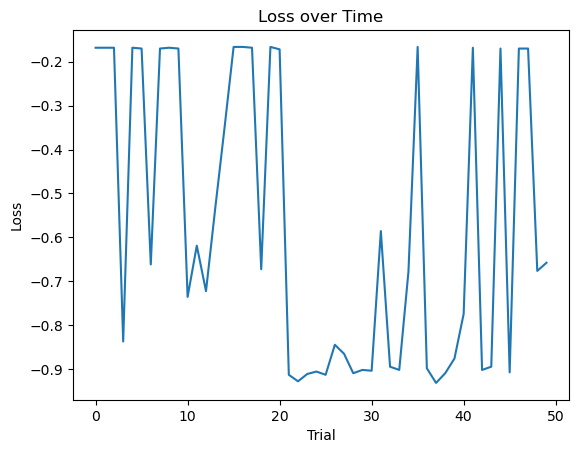

In [23]:
# plot the loss over time
import matplotlib.pyplot as plt
loss = [x['result']['loss'] for x in trials.trials]
plt.plot(loss)
plt.title('Loss over Time')
plt.xlabel('Trial')
plt.ylabel('Loss')
plt.show()

In [24]:
crit = {0: 'entropy', 1: 'gini'}
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {0: 10, 1: 50, 2: 350, 3: 550, 4: 750, 5: 1200, 6: 1300, 7: 1500}

print(crit[best['criterion']])
print(feat[best['max_features']])
print(est[best['n_estimators']])

gini
auto
1500


In [25]:
trainedforest = RandomForestClassifier(criterion = crit[best['criterion']], max_depth = int(best['max_depth']), 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']]).fit(training_objects,training_labels)



                                       
predictionforest = trainedforest.predict(testing_objects)
predicted = trainedforest.predict(objects)


print(confusion_matrix(testing_labels,predictionforest))
print(f'A acurácia global é de : {round(accuracy_score(testing_labels,predictionforest),4)}')
print(classification_report(testing_labels,predictionforest))
acc5 = accuracy_score(testing_labels,predictionforest)
kappa = cohen_kappa_score(testing_labels, predictionforest)
print(f'O kappa é de : {round(kappa,4)}')

[[13  0  0  0  0  1]
 [ 0  4  2  2  0  0]
 [ 0  0 11  0  0  0]
 [ 0  0  0 11  0  0]
 [ 0  0  0  0  6  1]
 [ 0  0  0  0  0  9]]
A acurácia global é de : 0.9
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       1.00      0.50      0.67         8
           2       0.85      1.00      0.92        11
           3       0.85      1.00      0.92        11
           4       1.00      0.86      0.92         7
           5       0.82      1.00      0.90         9

    accuracy                           0.90        60
   macro avg       0.92      0.88      0.88        60
weighted avg       0.92      0.90      0.89        60

O kappa é de : 0.8783


In [26]:
# Replace segments with the predicted classes
clf = np.copy(segments)

mask = np.isin(clf, segment_ids)
clf[mask] = predicted[np.searchsorted(segment_ids, clf[mask])]

mask = np.sum(np.abs(img), axis=2)
mask[mask > 0.0] = 1.0
mask[mask == 0.0] = -1.0
clf = np.multiply(clf, mask)
clf[clf < 0] = -9999.0


# Convert 0 to maxvalueclass+1
clf[clf == 0] = np.max(clf) + 1


# Save the result to raster
clfds = driverTiff.Create(r'D:\PROJETO_SC\DADOS_CLASSIFICADOR\CLASSIFIED1.tif', naip_ds.RasterXSize, naip_ds.RasterYSize,
                          1, gdal.GDT_Float32)
clfds.SetGeoTransform(naip_ds.GetGeoTransform())
clfds.SetProjection(naip_ds.GetProjection())
clfds.GetRasterBand(1).SetNoDataValue(-9999.0)
clfds.GetRasterBand(1).WriteArray(clf)
clfds = None

print('Done!')

Done!


# Accuracy

## RFECV (number of features)

In [27]:
erro

NameError: name 'erro' is not defined

In [ ]:
from sklearn.feature_selection import RFECV

# Init, fit
rfecv = RFECV(
    estimator=trainedforest,
    min_features_to_select=3,
    step=1,
    n_jobs=-1,
    scoring="r2",
    cv=5,
)

_ = rfecv.fit(img[ground_truth > 0], ground_truth[ground_truth > 0])

print(f"o número de features a serem selecionadas é de: {rfe.support_.sum()}")

## RFE (Recursive feature selection)

In [ ]:
## RFE 
rfe = RFE(estimator=trainedforest, n_features_to_select=6, step = 1)


rfe.fit(img[ground_truth > 0], ground_truth[ground_truth > 0])

for i in range(img.shape[2]):
	print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

In [ ]:
import numpy as np
from sklearn import metrics
 
# read original image to get info for raster dimensions
naip_fn = r'C:\Users\10333076966\Documents\Temp\TestePCA\CLASSIFICADOR\BSI_NDVI_B1B2B3B4_NDWI_subset.tif'
driverTiff = gdal.GetDriverByName('GTiff')
naip_ds = gdal.Open(naip_fn)
 
# rasterize test data for pixel-to-pixel comparison
test_fn = r'C:\Users\10333076966\Documents\Temp\IMAGENS_PARA_TESTE\Amostras\test_data.shp'
test_ds = ogr.Open(test_fn)
lyr = test_ds.GetLayer()
driver = gdal.GetDriverByName('MEM')
target_ds = driver.Create('', naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_UInt16)
target_ds.SetGeoTransform(naip_ds.GetGeoTransform())
target_ds.SetProjection(naip_ds.GetProjection())
options = ['ATTRIBUTE=id']
gdal.RasterizeLayer(target_ds, [1], lyr, options=options)
 
truth = target_ds.GetRasterBand(1).ReadAsArray()  # truth/test data array
 
pred_ds = gdal.Open(r'C:\Users\10333076966\Documents\Temp\TestePCA\classified_result_xgbost.tif')  
pred = pred_ds.GetRasterBand(1).ReadAsArray()  # predicted data array
idx = np.nonzero(truth) # get indices where truth/test has data values
cm = metrics.confusion_matrix(truth[idx], pred[idx])  # create a confusion matrix at the truth/test locations
scores = metrics.accuracy_score(truth[idx], pred[idx])

# pixel accuracy
print(cm)


print(scores)

In [ ]:
#level 2 scores